# Özel (Custom) Transformer

In [1]:
import pandas as pd
import seaborn as sns

👉 Bu veri setini kullanacağız:

In [2]:
data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Veri setindeki her bir gözlem, bir ürünün bir `seller_state`’ten bir `customer_state`’e teslim edilmesini temsil eder.  
- Diğer sütunlar, her bir ürünün paketleme özelliklerini açıklar.

🎯 Hedef, sipariş ile teslimat arasındaki gün sayısıdır.

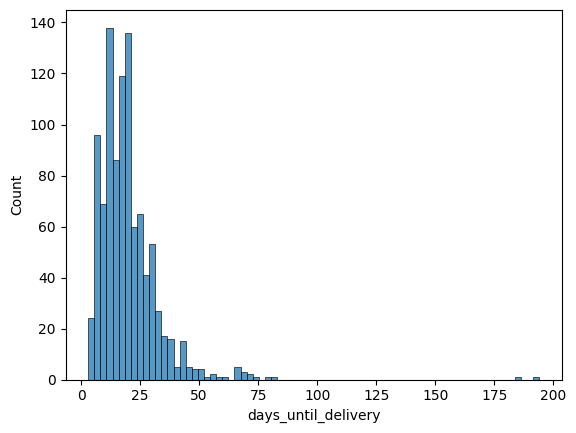

In [3]:
#  Hedefi kontrol et
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👉 `pipe` adlı bir scikit-learn pipeline oluşturun:

- Boyut feature’larından (`dimensions`) bir `volume` feature’ı türetin
- Eğitim için orijinal ürün boyut feature’larını koruyun
- Tüm sayısal feature’ları ölçekleyin
- Kategorik feature’ları encode edin
- Varsayılan ayarlarla bir `Ridge` regresyon estimator’ı ekleyin

**Not:** Bu challenge için holdout yöntemi yok sayılacaktır; yani `train_test_split` kullanmanıza gerek yoktur!

<details><summary><strong>İpuçları</strong></summary>

- Ön işlenmiş feature matrisinizi oluşturmanın birçok yolu vardır (`ColumnTransformer` ve/veya `FeatureUnion` kullanarak). 
    
- Dönüştürülmüş feature matrisiniz garip görünüyorsa, bunun nedeni `OneHotEncoder(sparse_output=True)` varsayılan davranışıyla matrisin "sparse" olarak saklanması olabilir. Bunu tekrar dense bir matrise çevirmek için `.todense()` kullanın.

- Varsayılan NumPy array çıktısı yerine sütun adlarıyla birlikte bir Pandas DataFrame çıktısı almak için, final pipeline’ınızda `.set_output(transform='pandas')` kullanın. (Bunu her bir transformer üzerinde tek tek ayarlamanıza gerek yoktur. Pipeline üzerinde ayarlarsanız, bunu alt aşamalara da aktarır.)

</details>

<br>

<details><summary><strong>Daha fazla ipucu: adım adım yönlendirme</strong> (yalnızca takılırsanız açın)</summary>

Pipeline’ı oluşturmanın en kolay yolu budur.

1. Uzunluk, genişlik ve yükseklik verildiğinde hacmi hesaplayan bir python `function` oluşturun.
2. Aşağıdakilerden oluşan bir hacim hesaplayıcı pipeline oluşturun:
   1. Python `function`’ınızı kullanan bir `FunctionTransformer`.
   1. Ardından bir scaler
3. `ColumnTransformer` kullanarak tam bir preprocessor oluşturun:
   - Orijinal sayısal feature’lar için bir scaler.
   - Kategorik feature’lar için bir encoder.
   - Uzunluk, genişlik ve yükseklik feature’ları için hacim hesaplayıcı pipeline’ınız.
4. Son olarak, tam preprocessor’ınızı ve ardından `Ridge` modelini içeren bir pipeline oluşturun.

</details>

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.pipeline import FeatureUnion

In [5]:
X = data.drop(columns=['days_until_delivery'])
y = data['days_until_delivery']
X.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40
1,RJ,SP,700,65,18,28
2,RJ,SP,1825,53,10,40
3,RJ,SP,1825,53,10,40
4,RJ,SP,1825,53,10,40


In [6]:
def multiply(df):
    return pd.DataFrame(
        df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]
    )


volume_computer = Pipeline(
    [
        ("compute_volume", FunctionTransformer(multiply)),
        ("scale_volume", MinMaxScaler()),
    ]
)

final_preprocessor = ColumnTransformer(
    [
        (
            "num_scaler",
            MinMaxScaler(),
            make_column_selector(dtype_include="int64"),
        ),
        (
            "cat_encoder",
            OneHotEncoder(
                handle_unknown="ignore", 
                sparse_output=False, 
                drop="if_binary"
            ),
            make_column_selector(dtype_include="object"),
        ),
        (
            "volume_computer",
            volume_computer,
            ["product_length_cm", "product_height_cm", "product_width_cm"],
        ),
    ]
).set_output(transform="pandas")

final_preprocessor

ColumnTransformer(transformers=[('num_scaler', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13d267d40>),
                                ('cat_encoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13cc9cf20>),
                                ('volume_computer',
                                 Pipeline(steps=[('compute_volume',
                                                  FunctionTransformer(func=<function multiply at 0x13bbe2ca0>)),
                                                 ('scale_volume',
                                                  MinMaxScaler())]),
                                 ['product_length_cm', 'product_height_cm',
                                  'product_width_cm'])])

In [8]:
final_preprocessor.fit_transform(X)

,num_scaler__product_weight_g,num_scaler__product_length_cm,num_scaler__product_height_cm,num_scaler__product_width_cm,cat_encoder__customer_state_AL,cat_encoder__customer_state_AM,cat_encoder__customer_state_AP,cat_encoder__customer_state_BA,cat_encoder__customer_state_CE,cat_encoder__customer_state_DF,...,cat_encoder__customer_state_RJ,cat_encoder__customer_state_RN,cat_encoder__customer_state_RO,cat_encoder__customer_state_RS,cat_encoder__customer_state_SC,cat_encoder__customer_state_SE,cat_encoder__customer_state_SP,cat_encoder__customer_state_TO,cat_encoder__seller_state_SP,volume_computer__x0
0,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
1,0.020067,0.548780,0.147727,0.158879,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125218
2,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
3,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
4,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.558528,0.524390,0.602273,0.121495,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.344015
996,0.019231,0.243902,0.147727,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.095108
997,0.065217,0.304878,0.113636,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.088836
998,0.289298,0.390244,0.522727,0.056075,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.174302


In [9]:
preprocessor = ColumnTransformer(
    [
        (
            "num_scaler",
            MinMaxScaler(),
            make_column_selector(dtype_include="int64"),
        ),
        (
            "cat_encoder",
            OneHotEncoder(
                handle_unknown="ignore", sparse_output=False, drop="if_binary"
            ),
            make_column_selector(dtype_include="object"),
        ),
    ]
)


def multiply(df):
    return pd.DataFrame(
        df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]
    )


volume_computer = Pipeline(
    [
        (
            "compute_volume",
            FunctionTransformer(multiply),
        ),
        ("scale_volume", MinMaxScaler()),
    ]
)

final_preprocessor2 = FeatureUnion(
    [("preprocesses", preprocessor), ("compute_volume", volume_computer)]
).set_output(transform="pandas")

final_preprocessor2

FeatureUnion(transformer_list=[('preprocesses',
                                ColumnTransformer(transformers=[('num_scaler',
                                                                 MinMaxScaler(),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13cc9c800>),
                                                                ('cat_encoder',
                                                                 OneHotEncoder(drop='if_binary',
                                                                               handle_unknown='ignore',
                                                                               sparse_output=False),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13bbc4770>)])),
                               ('compute_volume',
                                Pipeline(steps=[('compute_volume',
                                                 FunctionTransformer(func=<function multiply at 0x13d401080>)),
                                                ('scale_volume',
                                                 MinMaxScaler())]))])

In [11]:
final_preprocessor2.fit_transform(X)

,num_scaler__product_weight_g,num_scaler__product_length_cm,num_scaler__product_height_cm,num_scaler__product_width_cm,cat_encoder__customer_state_AL,cat_encoder__customer_state_AM,cat_encoder__customer_state_AP,cat_encoder__customer_state_BA,cat_encoder__customer_state_CE,cat_encoder__customer_state_DF,...,cat_encoder__customer_state_RJ,cat_encoder__customer_state_RN,cat_encoder__customer_state_RO,cat_encoder__customer_state_RS,cat_encoder__customer_state_SC,cat_encoder__customer_state_SE,cat_encoder__customer_state_SP,cat_encoder__customer_state_TO,cat_encoder__seller_state_SP,x0
0,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
1,0.020067,0.548780,0.147727,0.158879,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125218
2,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
3,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
4,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.558528,0.524390,0.602273,0.121495,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.344015
996,0.019231,0.243902,0.147727,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.095108
997,0.065217,0.304878,0.113636,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.088836
998,0.289298,0.390244,0.522727,0.056075,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.174302


In [15]:
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ('preprocessing', final_preprocessor),
    ('linear_regression', Ridge())
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13d267d40>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13cc9cf20>),
                                                 ('volume_computer',
                                                  Pipeline(steps=[('compute_volume',
                                                                   FunctionTransformer(func=<function multiply at 0x13bbe2ca0>)),
                                                                  ('scale_volume',
                                                                   MinMaxScaler())]),
                                                  ['product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm'])])),
                ('linear_regression', Ridge())])

#### 🧪  pipe'ını test et

In [16]:
from nbresult import ChallengeResult

pipe_test = pipe

# Çökmediğini kontrol edin
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D1-S-Data-Custom-Transformer/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.48s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train ve Predict

👇 `data`’nın tüm eğitim veri setiniz olduğunu varsayalım.

- Bu veri seti üzerinde pipeline’ınızı `cross_validate` edin (❗️düşük $R^2$ skorları beklenmektedir)
- Şimdi de yeni bir sipariş aldığınızı varsayın: `new_data`  
  Teslimat süresini tahmin edin ve sonucu `prediction` adlı değişkende saklayın

In [17]:
new_data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe, X, y, cv=10, scoring='r2').mean()

/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.15838731743600062

In [19]:
pipe.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13d267d40>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13cc9cf20>),
                                                 ('volume_computer',
                                                  Pipeline(steps=[('compute_volume',
                                                                   FunctionTransformer(func=<function multiply at 0x13bbe2ca0>)),
                                                                  ('scale_volume',
                                                                   MinMaxScaler())]),
                                                  ['product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm'])])),
                ('linear_regression', Ridge())])

In [20]:
prediction = pipe.predict(new_data)
prediction

array([20.65994518])

In [21]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D1-S-Data-Custom-Transformer/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.58s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Tebrikler. Not defterinizi eklemeyi, kaydetmeyi ve göndermeyi unutmayın.